In [1]:
import battery_parser as bp
import os
import pandas as pd
import numpy as np
import re
import copy
import itertools
import matplotlib.pyplot as plt
pd.options.plotting.backend = 'matplotlib'
import plotly as py
import plotly_express as px


In [2]:
root_dir  = r'D:\!Science\Физтех\Циклирования\Результаты'
file_statistic_path = os.path.join(root_dir, r'File_statistics.csv')
file_statistic = bp.exporting.load_experiment(file_statistic_path)


In [35]:
statistic_dir = os.path.join(root_dir, r'Статистика')
statistics = {}
for step in range(1, 2):
    for pouch, _ in file_statistic[file_statistic['Step_id']==step].groupby('ID'):
        statistics_path = os.path.join(statistic_dir,fr'{step}',fr'{pouch}.csv' )
        statistics[pouch] = bp.exporting.load_experiment(statistics_path, parse_dates = ['Datetime_min', 'Datetime_max'])

In [32]:
#Импорт данных типа csv. 
root_dir  = r'D:\!Science\Физтех\Циклирования\Результаты'
lst_data = bp.importing.list_files(os.path.join(root_dir, 'Данные', '1'), 'csv')#Получить список всех файлов в папке.
data_import = [bp.exporting.load_experiment(i) for i in lst_data]
for data, path in zip(data_import, lst_data):
    pouch_id = os.path.splitext(os.path.split(path)[1])[0]
    data.attrs.setdefault('id', pouch_id)
    
    group_marker=[(data['Time'] < data['Time'].shift()).cumsum(), (data['Step Type'] != data['Step Type'].shift()).cumsum()]
    grouper = data.groupby(group_marker)
    cycle_column = pd.concat([pd.DataFrame([i]*len(idxs), index=idxs, columns=['Cycle']) for i, idxs in enumerate(grouper.indices.values())])
    data[cycle_column.columns] = cycle_column

In [41]:
borders = {'LFP':[2.51,3.64, 280.0], 'NMC':[2.51, 4.19, 195.0],'LTO':[1.51, 2.84, 102.0]}
class Check_pattern:  # TODO перенести в файл с обработкой (который будет)
    """
    Creates object that checks if given value list/dataframe corresponds to given pattern.
    Pattern engine use slicing window with size equal to pattern length. Each pattern element is dict in form {'column_name':(compare operation, value)} for one condition per column or {'column_name':[(compare operation1, value1), (compare operation2, value2)]} for multiple conditions for the column.
    Args:
        pattern:
    """

    def __init__(self, pattern:list, ):
        self.length = len(pattern)
        self.pattern = [self.transform_pattern(step) for step in pattern]


    def __call__(self, split: pd.DataFrame):
        """
        Checks if values in list are consistent with pattern. List length should be
        equal to pattern length.
        Args:
            split (): list of values.

        Returns:

        """
        assert len(self.pattern) == len(split)
        checks = []
        for series, conditions in zip(split.reset_index(drop=True).iterrows(), self.pattern):
            check = self.check_series(series[1], conditions)
            if not check:
                return False
            checks.append(check)
        return all(checks)

    def __len__(self):
        return len(self.pattern)

    @staticmethod
    def transform_pattern(step):
        if isinstance(step, list):
            return step
        step_transform = []
        for key in step.keys():
            if len(step[key]) > 1 and isinstance(step[key], list):
                step_transform.extend([(key, *comparator ) for comparator in step[key]])
            else:
                step_transform.append((key, *step[key]))
        return step_transform


    def check_series(self, series, conditions):
        results = []
        for column, operator, value in conditions:
            result = self.check_condition(a=series[column], b=value, operation=operator)
            if not result:
                return False
            results.append(result)
        return all(results)

    @staticmethod
    def check_condition(a, b, operation):
        match operation:
            case 'less':
                return a < b
            case 'more':
                return a > b
            case 'equal':
                return a == b
            case 'contain':
                return b in a
            case 'approx':
                borders = [b*0.98, b*1.02]
                borders.sort()
                return (a >= borders[0]) and (a <= borders[1])


def window_slider(window_size, stat_data):
    len_data = len(stat_data)
    for i in range(len_data-window_size+1):
        yield i, i+window_size

def find_pattern(statistics: pd.DataFrame, pattern: list):
    pattern_checker = Check_pattern(pattern)
    window_size = len(pattern_checker)

    slices = window_slider(window_size, statistics)
    roll = {statistics.iloc[a].name:True for a, b in slices if pattern_checker(statistics.iloc[a:b])}
    roll = pd.DataFrame.from_dict(roll, 'index', columns=['result'])
    windows = []
    for i in roll[roll['result']].index:
        start_index = i
        end_index =  start_index + window_size
        windows.append(list(range(start_index, end_index)))
    return windows

class Pattern_dict:

    def __init__(self, e_min, e_max, p_max, duration_column='Time_range'):
        self._e_min = e_min
        self._e_max = e_max
        self._p_max = p_max
        self._p = {}
        self.duration_column = duration_column
        self._create_pattern()
        self._create_dst()

    def __getitem__(self, item):
        return self._p[item]

    def __setitem__(self, key, value):
        self._p[key] = value

    def set_duration(self, seconds):
        return [(self.duration_column, 'equal', seconds)]

    def _create_pattern(self):
        self._p.update(
            {
                'discharge':[('Step Type','contain', ' dchg')],
                'charge':[('Step Type','contain', ' chg')],
                'rest':[('Step Type','contain', 'rest')]
             }
                       )


        self._p.update(
            {
            'discharge_full':self._p['discharge']+[('E_last', 'less', self._e_min)],
            'charge_full':self._p['charge']+[('E_last', 'more',self._e_max)]
            }
        )

    def _create_dst(self):
        power_percent = [0.0, 0.125, 0.25, -0.125, 0.0,
                            0.125, 0.25, -0.125, 0.0, 0.125,
                            0.25, -0.125, 0.0, 0.125, 1.0,
                            0.625, -0.25, 0.25, -0.5, 0.0]
        power = [i*self._p_max for i in power_percent]
        time_a = [16,28,12,8,16,
                    24,12,8,16,24,
                    12,8,16,36,8,
                    24,8,32,8,44]
        time_b = [16,28,12,8,16,
                    24,12,8,16,24,
                    12,8,16,36,8,
                    120,8,32,8,44]
        dst_all = []
        for i in power:
            if i>0:
                step='cp dchg'
            elif i < 0:
                step = 'cp chg'
            elif i == 0:
                step = 'rest'
            one_move = [('Step Type', 'contain', step), ('P_mean','approx', -i)]
            if i == 0:
                one_move = [('Step Type', 'contain', step)]
            dst_all.append(one_move)

        dst_b = []
        for step, time in zip(dst_all, time_b):
            times = self.set_duration(time)
            dst_b.append(step+times)

        dst_a = []
        for step, time in zip(dst_all, time_a):
            times = self.set_duration(time)
            dst_a.append(step+times)
        self._p.update({'dst_all':dst_all, 'dst_a':dst_a, 'dst_b':dst_b})
def extract_patterns(data, patterns):
    slices = []
    for pattern in patterns:
        windows = find_pattern(data, pattern)
        selection = windows[0]
        slices.append(data.loc[selection])
        data = data.loc[selection[-1]+1:]
    slices.append(data)
    return slices

def extract_dst(data, borders):
    slices = extract_patterns(data, borders)
    start = slices[0].index[0]+1
    finish = slices[1].index[0]
    return [data.loc[start:finish], data.loc[finish+1:]]

def extract_ic(data, pattern):
    composition = []
    for i in find_pattern(data, pattern):
        composition.extend(i)
    return [data.loc[composition], data.loc[composition[-1]+1:]]

def extract_chemistry(pouch):
    return re.findall(r'([A-Z]{3})', pouch)[0]

In [42]:
def extract_slices(statistics, pouch):
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    patterns = [[p['discharge_full'],
                p['rest'],
                p['charge_full'],
                p['discharge_full']],

                [p['rest']+p.set_duration(120*60),
                p['discharge']+p.set_duration(10),
                p['rest']+p.set_duration(60*60)],

                [p['discharge']+p.set_duration(30),
                 p['discharge']+p.set_duration(5)],


                ]
    dst_borders =   [[p['charge_full']],
                [p['discharge_full']]]

    pattern_cc_ic = [[p['rest'],
                     p['discharge_full'],
                    p['rest'],
                    p['charge_full']]]

    patterns_ic = [[p['discharge'],
                  p['rest']+p.set_duration(90*60)],

                 [p['discharge'],
                  p['rest']+p.set_duration(180*60)]
                 ]
    slices = extract_patterns(statistics, patterns)
    steps = slices[:3]
    slices = extract_dst(slices[-1], dst_borders)
    steps.append(slices[0])
    slices = extract_patterns(slices[-1], pattern_cc_ic)
    steps.append(slices[0])
    slices = extract_ic(slices[-1], patterns_ic[0])
    steps.append(slices[0])
    slices = extract_ic(slices[-1], patterns_ic[1])
    steps.append(slices[0])
    return steps

In [47]:
def process_1(step):
    processing1 = {}

    discharge_step = step[step['Step Type'].str.contains(' dchg')].iloc[-1]
    charge_step = step[step['Step Type'].str.contains(' chg')].iloc[-1]
    processing1['Q_dchg'] = discharge_step['Q_max']
    processing1['Q_chg'] = charge_step['Q_max']
    processing1['En_dchg'] = discharge_step['Energy_max']
    processing1['En_chg'] = charge_step['Energy_max']
    processing1['Time_start'] = step['Datetime_min'].min()
    processing1['T_mean'] = step['T_mean'].mean()
    processing1['T_max'] = step['T_max'].max()

    return processing1

def process_2(step):
    processing = {}
    discharge_step = step[step['Step Type'].str.contains(' dchg')].iloc[-1]
    processing['P'] = discharge_step['P_last']
    processing['T2_max'] =  step['T_max'].max()
    return processing

def process_3(step):
    processing = {}
    processing['R'] = (step['E_last'].iloc[0]- step['E_last'].iloc[1])/(step['I_mean'].iloc[0]- step['I_mean'].iloc[1])
    return processing

def process_4(step, pouch):
    processing = {}
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    if np.isin(step['Step Type'].unique() ,['cp dchg', 'cp chg', 'rest']).all():
        print('Fully dst')
    processing['Qdch_dst'] = -step[step['Step Type']== 'cp dchg']['Net Q'].sum()
    processing['En_dch_dst'] = -step[step['Step Type']== 'cp dchg']['Net Energy'].sum()
    processing['Qch_dst'] = step[step['Step Type']== 'cp chg']['Net Q'].sum()
    processing['En_ch_dst'] = step[step['Step Type']== 'cp chg']['Net Energy'].sum()
    processing['Q_dst'] = processing['Qdch_dst']-processing['Qch_dst']
    processing['n_dst_all'] = len(find_pattern(step, p['dst_all']))
    processing['n_dst_b'] = len(find_pattern(step, p['dst_b']))
    processing['n_dst_a'] = len(find_pattern(step, p['dst_a']))
    processing['T_mean_dst'] = step['T_mean'].mean()
    processing['T_max_dst'] = step['T_max'].max()
    if processing['n_dst_b']:
        last_idx = find_pattern(step, p['dst_b'])[0][0]
        processing['n_dst_a_before_b'] = len(find_pattern(step.loc[:last_idx], p['dst_a']))
    return processing

def process_5(step):
    processing = {}
    discharge_step = step[step['Step Type'].str.contains(' dchg')].iloc[-1]
    charge_step = step[step['Step Type'].str.contains(' chg')].iloc[-1]
    processing['Idch_ic'] = discharge_step['I_mean']
    processing['Ich_ic'] = charge_step['I_mean']
    return processing

def process_6(step, pattern):
    processing = {}
    processing['n_IC1'] = len(find_pattern(step, pattern=pattern))
    return processing

def process_7(step, pattern):
    processing = {}
    processing['n_IC2'] = len(find_pattern(step, pattern=pattern))
    return processing

In [51]:
slices = {}
for key, value in statistics.items():
    print(key)
    slices[key] = extract_slices(value, key)
    step_column = pd.concat([pd.DataFrame([i]*len(slice.index), index=slice.index, columns=['Step']) for i, slice in enumerate(slices[key])])
    value[step_column.columns] = step_column[step_column.columns]
step1_results = {}
for pouch, pouch_slices in slices.items():
    p = Pattern_dict(*borders[extract_chemistry(pouch)])
    patterns_ic = [[p['discharge'],
                      p['rest']+p.set_duration(90*60)],

                     [p['discharge'],
                      p['rest']+p.set_duration(180*60)]
                     ]

    result = {}
    result.update(process_1(pouch_slices[0]))
    result.update(process_2(pouch_slices[1]))
    result.update(process_3(pouch_slices[2]))
    result.update(process_4(pouch_slices[3], pouch))
    result.update(process_5(pouch_slices[4]))
    result.update(process_6(pouch_slices[5], patterns_ic[0]))
    result.update(process_7(pouch_slices[6], patterns_ic[1]))
    
    step1_results[pouch] = result

LFP1
LFP2
LFP3
LFP4
LFP5
LFP6
LFP7
LFP8
LTO11
LTO12
LTO13
LTO3
LTO4
LTO5
LTO6
LTO7
NMC10
NMC11
NMC12
NMC13
NMC14
NMC15
NMC6
NMC7
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst
Fully dst


In [76]:
specific_capacity = {}
cycles_number = {}
cycles = {}
for key, value in statistics.items():
    specific_capacity[key] = {}
    cycles_number[key] = {}
    specific_capacity[key]['dchg']=value[(value['Step']==4) & (value['Step Type']== 'cccv dchg')]['Q_max'].values[0]
    cycles_number[key]['dchg']=value[(value['Step']==4) & (value['Step Type']== 'cccv dchg')].index.values[0]
    cycles_number[key]['chg']=value[(value['Step']==4) & (value['Step Type']== 'cccv chg')].index.values[0]
    
    specific_capacity[key]['chg']=value[(value['Step']==4) & (value['Step Type']== 'cccv chg')]['Q_max'].values[0]
    


{'LFP1': {'dchg': 915, 'chg': 917},
 'LFP2': {'dchg': 914, 'chg': 916},
 'LFP3': {'dchg': 910, 'chg': 912},
 'LFP4': {'dchg': 914, 'chg': 916},
 'LFP5': {'dchg': 914, 'chg': 916},
 'LFP6': {'dchg': 895, 'chg': 897},
 'LFP7': {'dchg': 914, 'chg': 916},
 'LFP8': {'dchg': 914, 'chg': 916},
 'LTO11': {'dchg': 553, 'chg': 555},
 'LTO12': {'dchg': 553, 'chg': 555},
 'LTO13': {'dchg': 553, 'chg': 555},
 'LTO3': {'dchg': 553, 'chg': 555},
 'LTO4': {'dchg': 553, 'chg': 555},
 'LTO5': {'dchg': 553, 'chg': 555},
 'LTO6': {'dchg': 553, 'chg': 555},
 'LTO7': {'dchg': 553, 'chg': 555},
 'NMC10': {'dchg': 553, 'chg': 555},
 'NMC11': {'dchg': 553, 'chg': 555},
 'NMC12': {'dchg': 553, 'chg': 555},
 'NMC13': {'dchg': 553, 'chg': 555},
 'NMC14': {'dchg': 553, 'chg': 555},
 'NMC15': {'dchg': 553, 'chg': 555},
 'NMC6': {'dchg': 553, 'chg': 555},
 'NMC7': {'dchg': 553, 'chg': 555}}

C:\Users\sk804\AppData\Local\Temp\ipykernel_3160\19546603.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycles[key][i]['SoC'] = cycles[key][i]['Q']/specific_capacity[key][i]
C:\Users\sk804\AppData\Local\Temp\ipykernel_3160\19546603.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycles[key][i]['SoC'] = 1- cycles[key][i]['SoC']
C:\Users\sk804\AppData\Local\Temp\ipykernel_3160\19546603.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

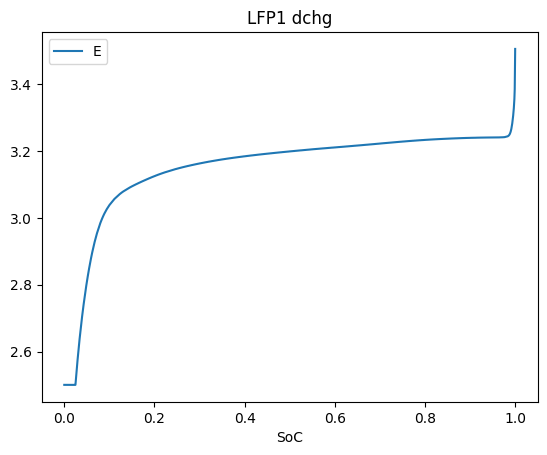

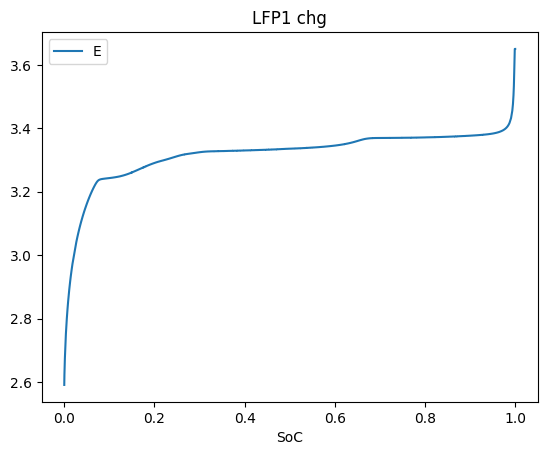

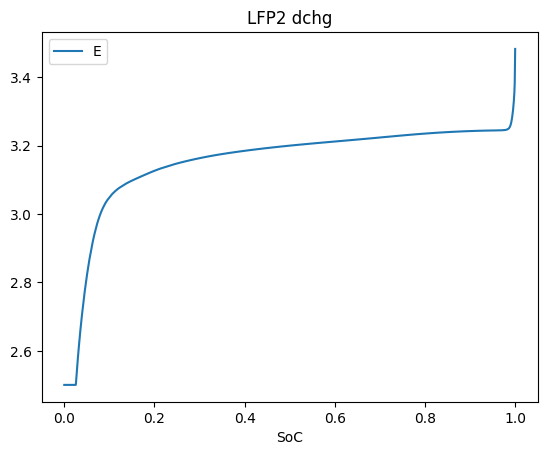

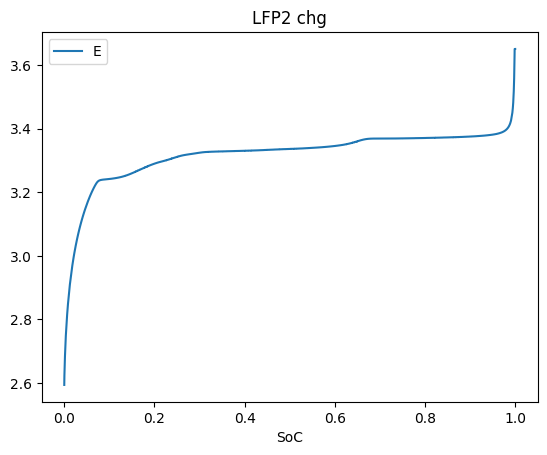

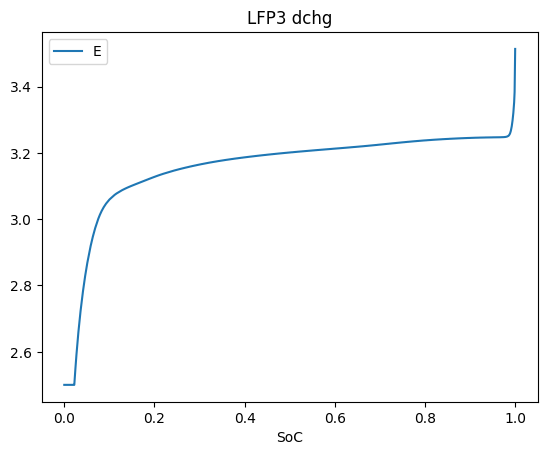

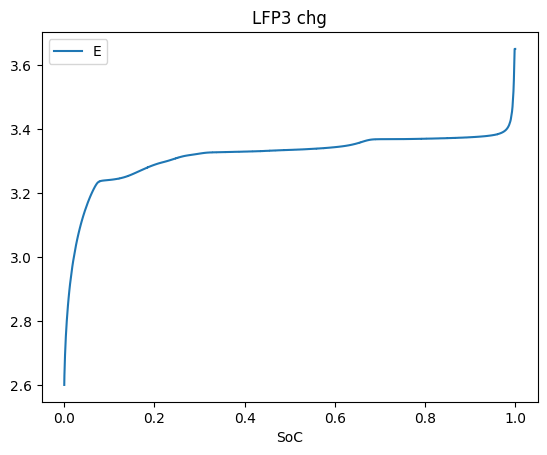

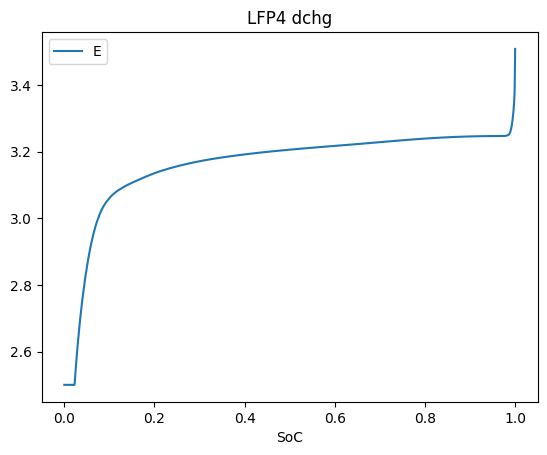

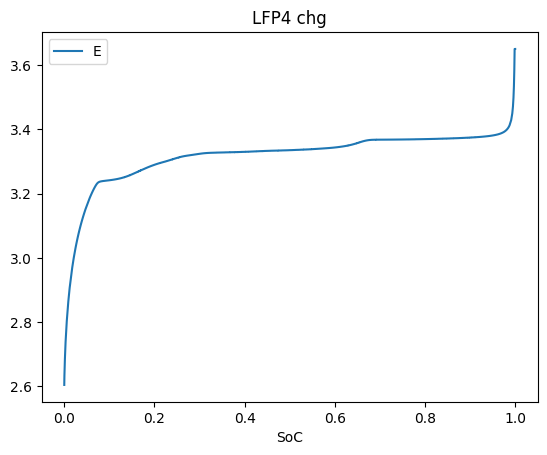

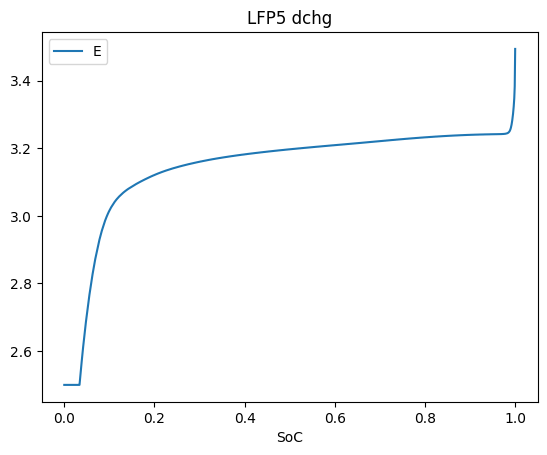

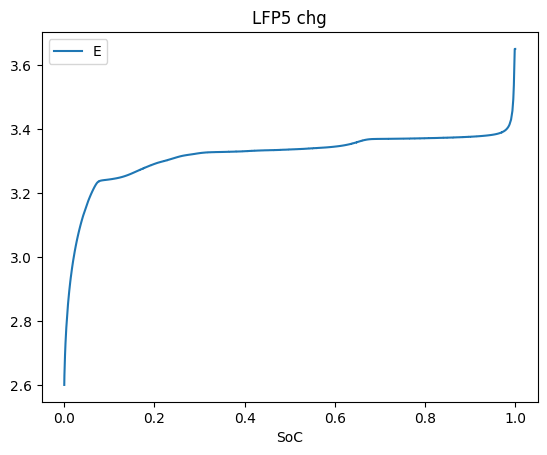

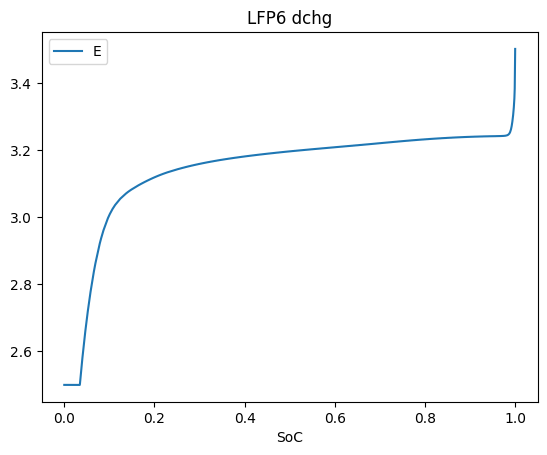

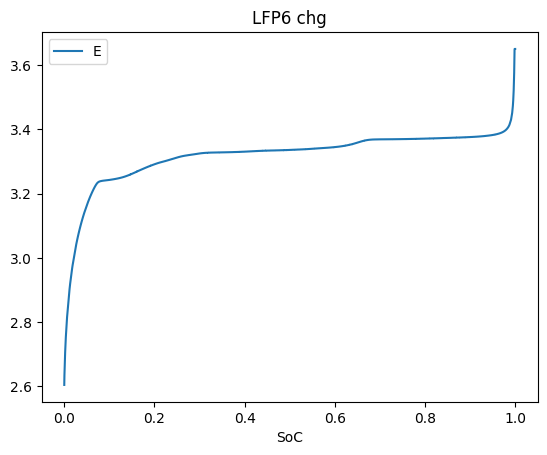

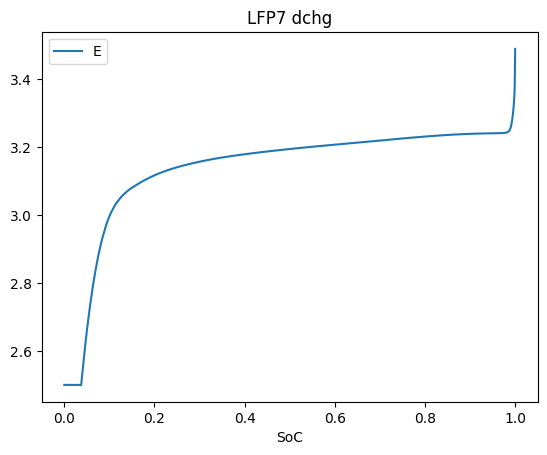

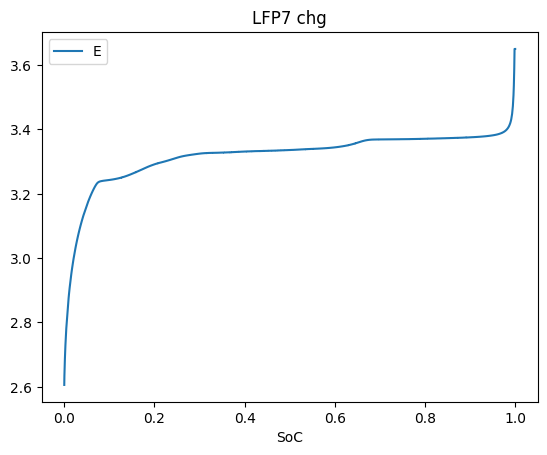

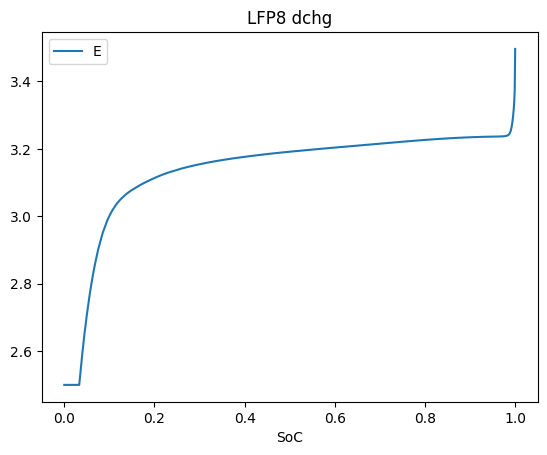

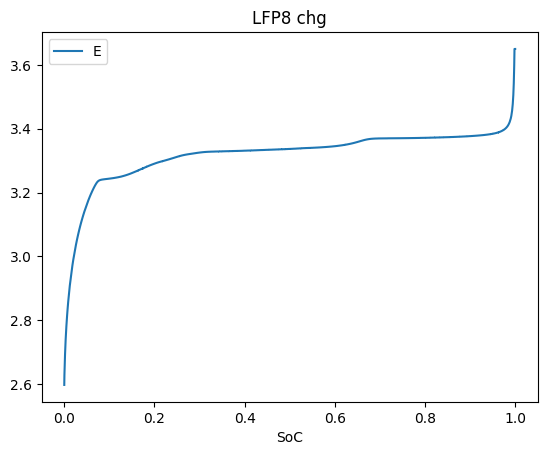

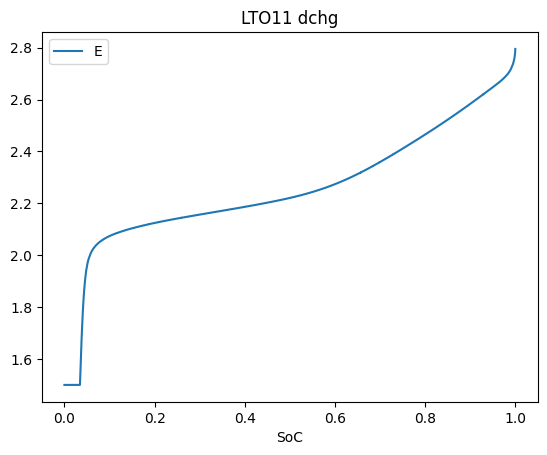

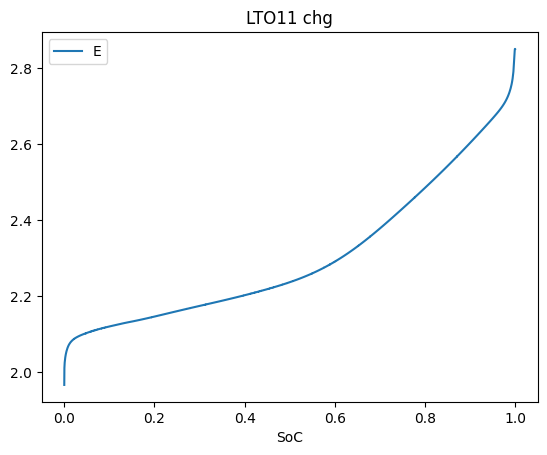

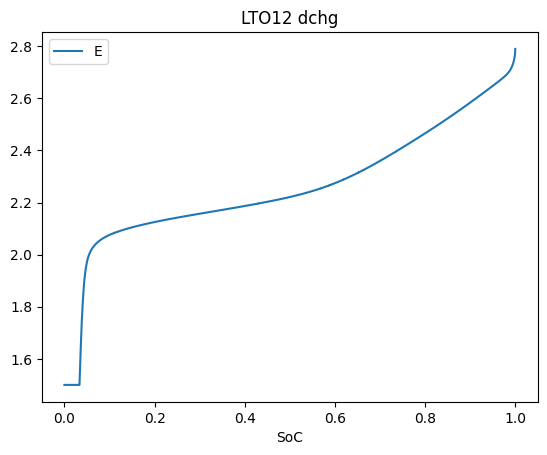

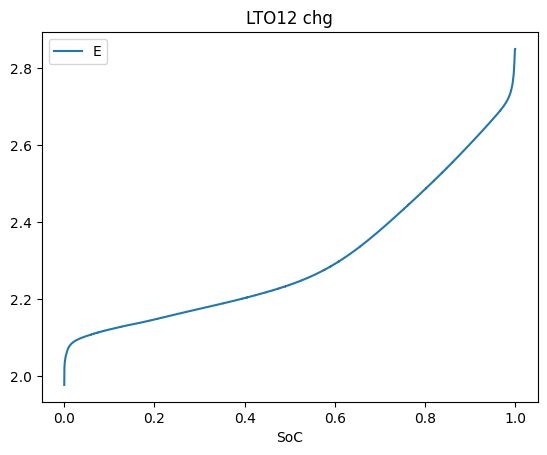

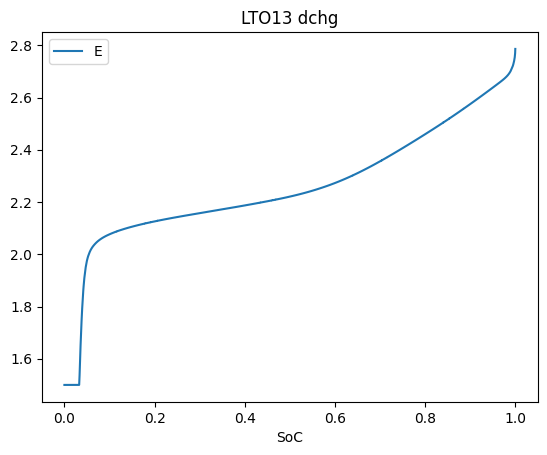

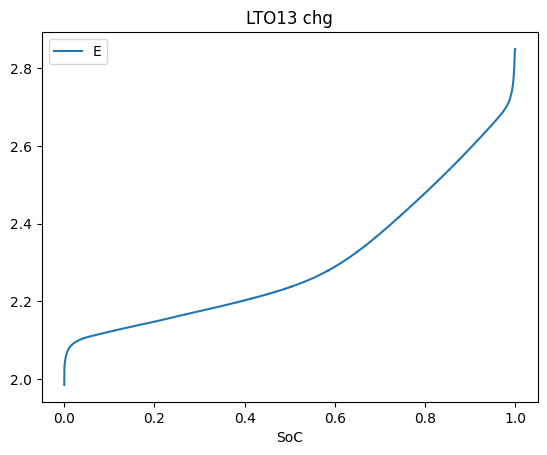

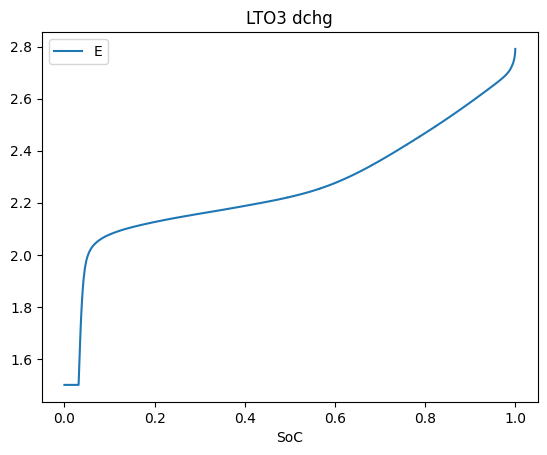

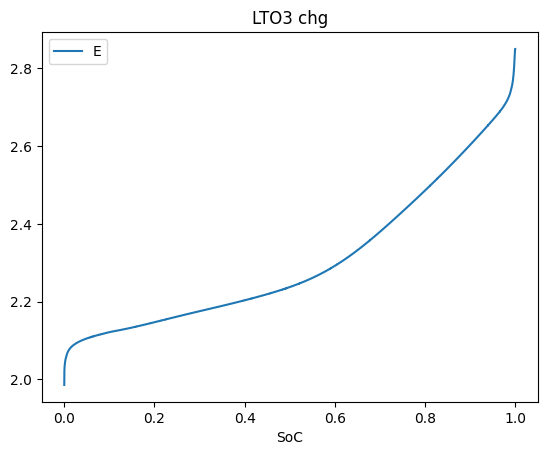

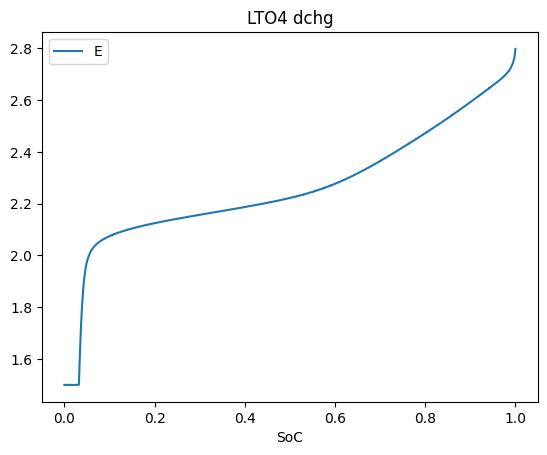

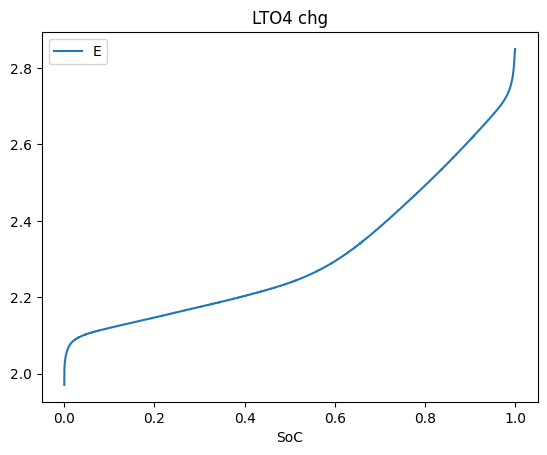

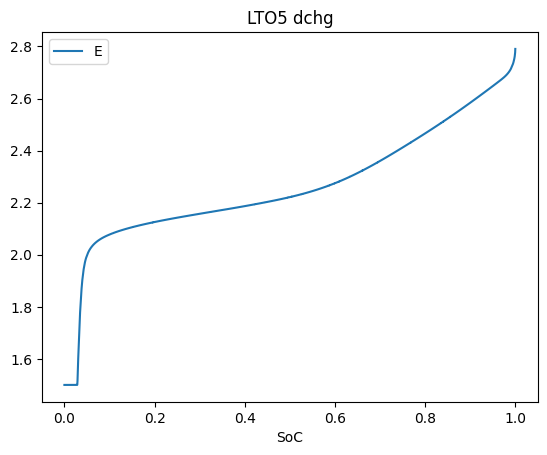

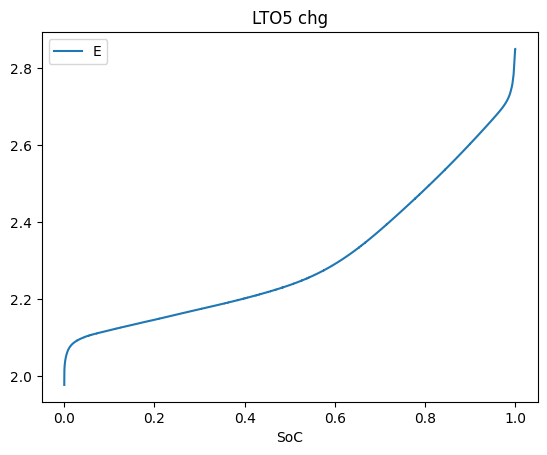

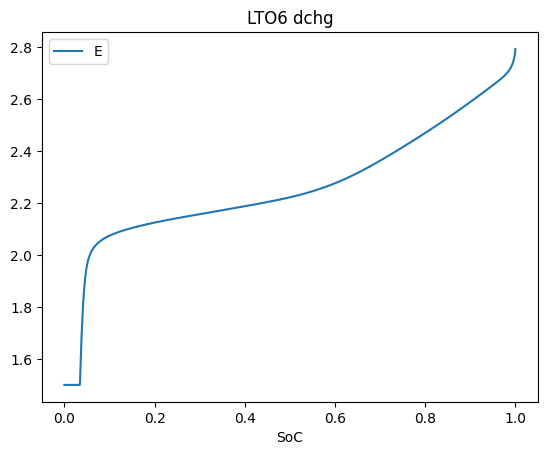

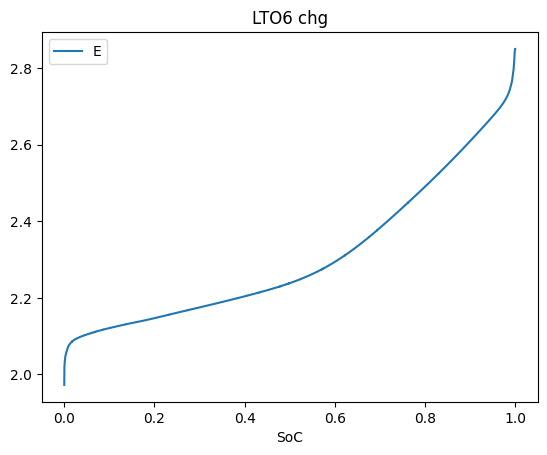

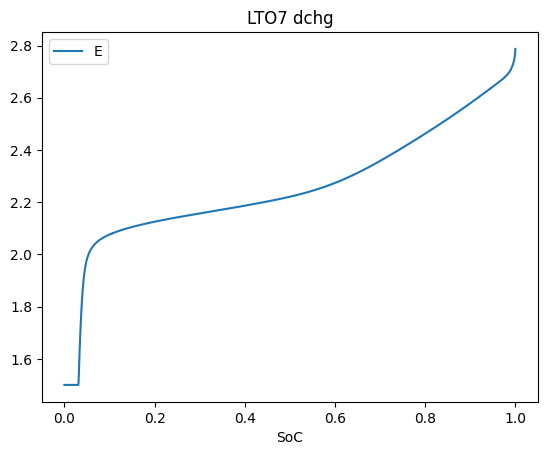

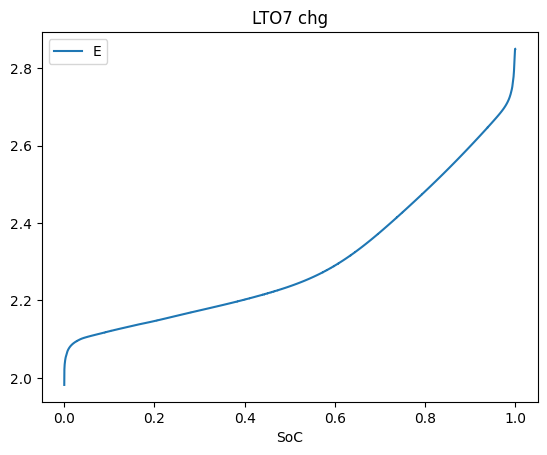

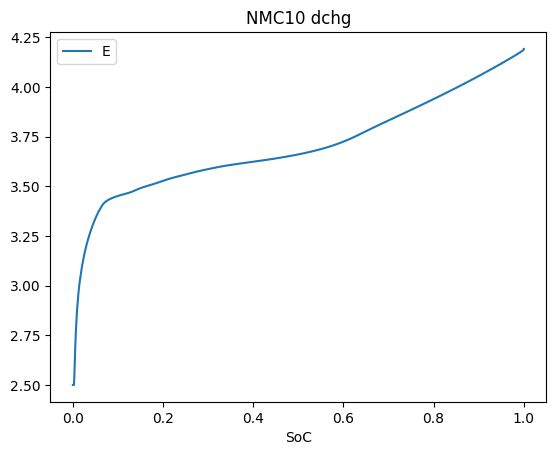

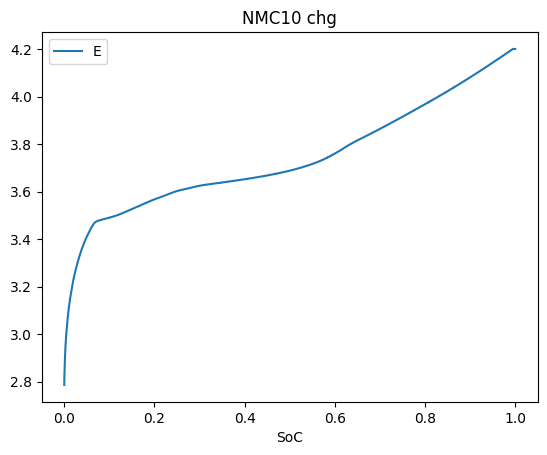

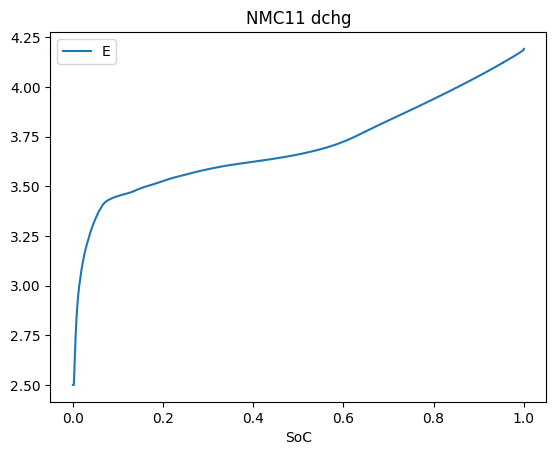

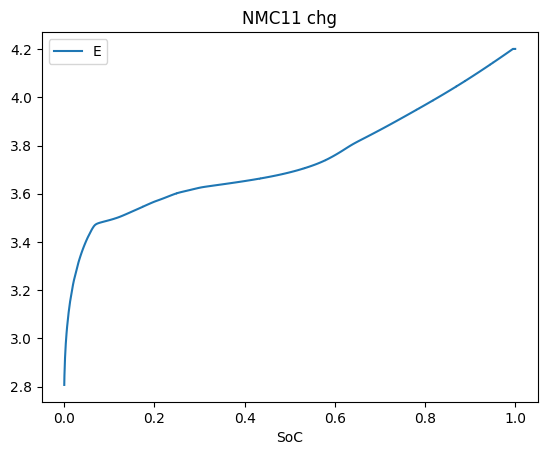

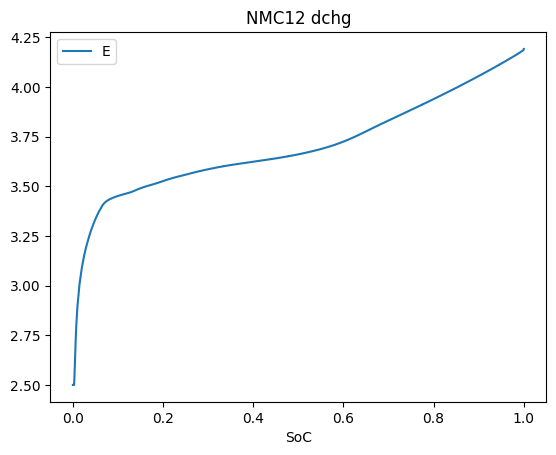

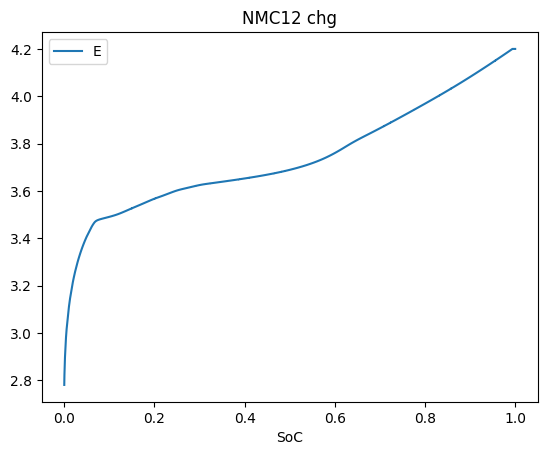

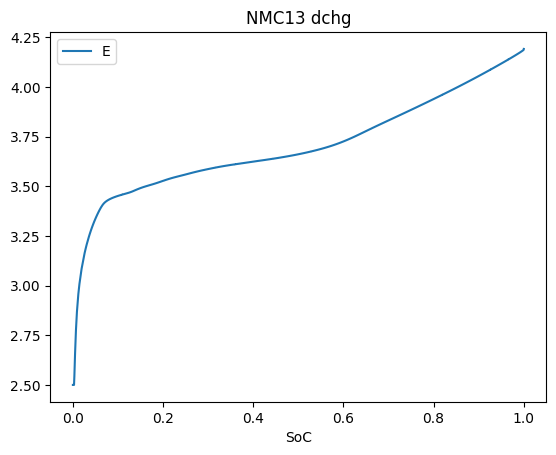

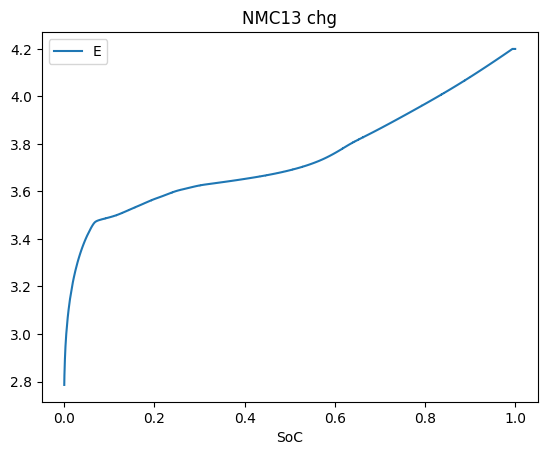

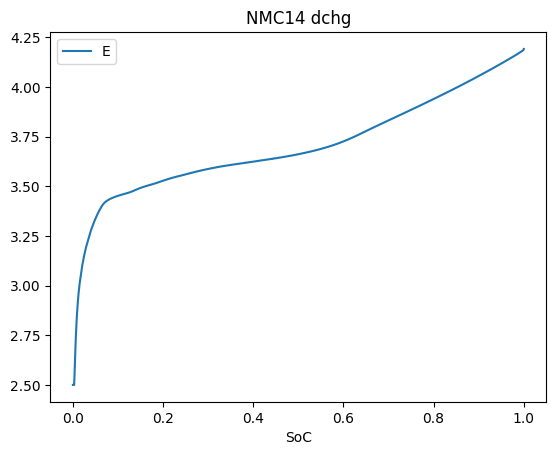

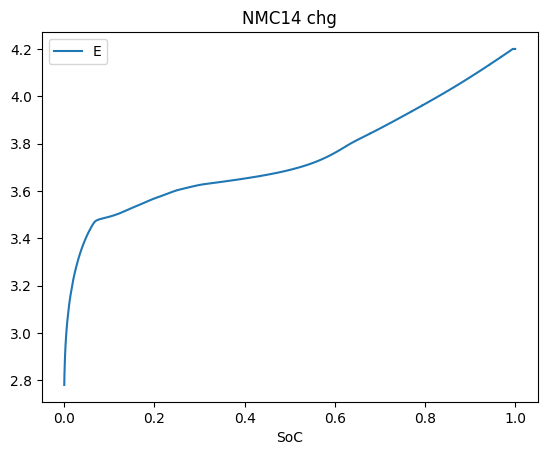

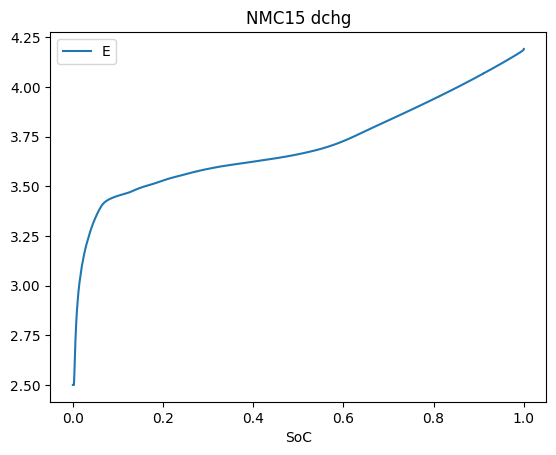

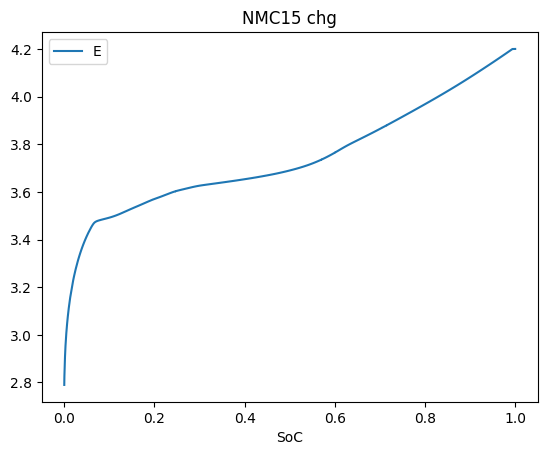

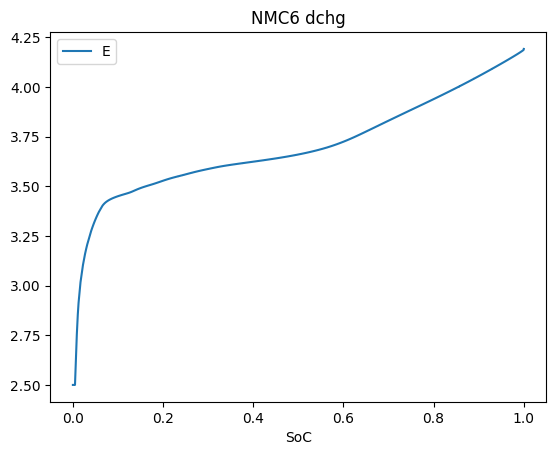

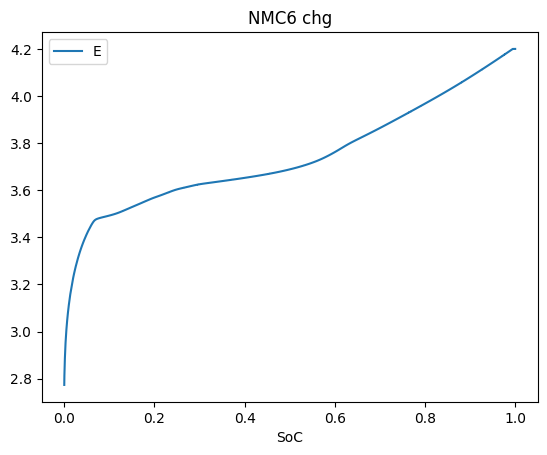

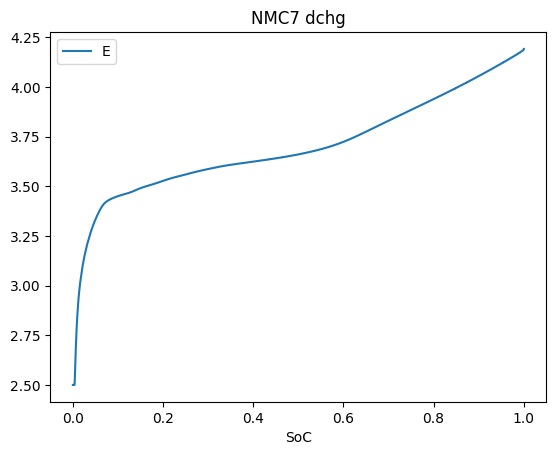

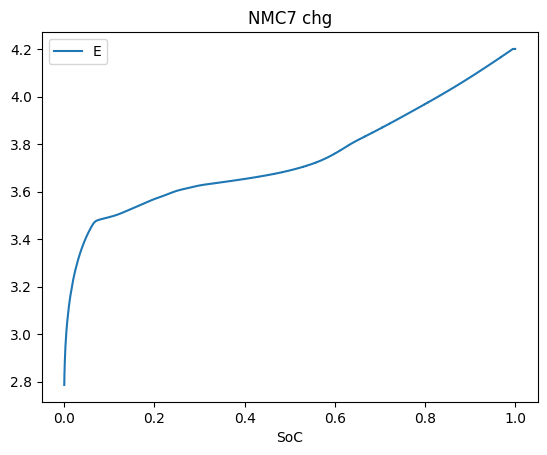

In [85]:
cycling_data = {}
variants = ['dchg', 'chg']
for i in data_import:
    cycling_data[i.attrs['id']] = i
for key, data in cycling_data.items():
    cycles[key] = {}
    for i in variants:
        cycles[key][i] = data[data['Cycle'] == cycles_number[key][i]]
        cycles[key][i]['SoC'] = cycles[key][i]['Q']/specific_capacity[key][i]
        if i == 'dchg':
            cycles[key][i]['SoC'] = 1- cycles[key][i]['SoC']
        cycles[key][i].plot(x='SoC', y = 'E', title=f'{key} {i}')
        bp.exporting.save_experiment(cycles[key][i], fr'{root_dir}\OCV\{key}_{i}.csv')